In [1]:
from scipy.io import wavfile

(source_fs, source_data) = wavfile.read('./data/01_source.wav')
(target_fs, target_data) = wavfile.read('./data/01_peak_compressor.wav')


In [2]:
import pandas as pd

In [3]:
source_df = pd.DataFrame(source_data, columns=['L', 'R'])
source_df.head()

,L,R
0,1,-1
1,-5,-6
2,-11,-12
3,-18,-17
4,-24,-24


In [4]:
target_df = pd.DataFrame(target_data, columns=['L', 'R'])
target_df.head()

,L,R
0,-1,0
1,-37,-37
2,-81,-81
3,-128,-128
4,-177,-178


In [5]:
source_df['L'].max(), target_df['L'].max()

(10790, 16537)

In [6]:
2 ** 15

32768

In [7]:
MAX_VALUE = 2 ** 15 - 1
MAX_VALUE

32767

In [8]:
len(source_df), len(target_df)

(1302647, 1302647)

In [9]:
# END_LOC = int(len(target_df) * 0.8)
TR_END_LOC = int(len(target_df) * 0.8 / 100) * 100
TR_END_LOC

1042100

## IT'S MONO

In [10]:
X_train_raw = source_df['L'][:TR_END_LOC]
len(X_train_raw)

1042100

In [11]:
X_test_raw = source_df['L'][TR_END_LOC:]
len(X_test_raw)

260547

In [12]:
y_train_raw = target_df['L'][:TR_END_LOC]
len(y_train_raw)

1042100

In [13]:
y_test_raw = target_df['L'][TR_END_LOC:]
len(y_test_raw)

260547

In [14]:
X_test_raw.iloc[:10]

1042100    3458
1042101    3469
1042102    3479
1042103    3485
1042104    3490
1042105    3491
1042106    3489
1042107    3485
1042108    3479
1042109    3471
Name: L, dtype: int16

In [15]:
# safe-checking data

In [16]:
# y_train_raw = -y_train_raw + 4000
# y_train_raw.iloc[0]

In [17]:
# y_test_raw = -y_test_raw + 4000
# y_test_raw.iloc[0]

## Preparing data for processing

In [18]:
def normalize_keeping_mean(arr, forced_abs=None):
    left_abs = np.abs(arr.mean() - arr.min())
    right_abs = np.abs(arr.max() - arr.mean())
    
    n = max(left_abs, right_abs)
    
    if (forced_abs is not None):
        n = forced_abs
    
    return np.clip(arr / n, -1.0, 1.0)

In [19]:
def normalize(arr, forced_abs=None, mean=None):
    left_abs = np.abs(arr.mean() - arr.min())
    right_abs = np.abs(arr.max() - arr.mean())
    
    n = max(left_abs, right_abs)
    
    if (forced_abs is not None):
        n = forced_abs
        
    if (mean is None):
        mean = arr.mean()
    
    
    return np.clip((arr - mean) / n, -1.0, 1.0)

In [20]:
import numpy as np

X_tr = np.array(list(map(lambda x: np.array(x), X_train_raw)))
X_tr_n = normalize(X_tr, forced_abs=MAX_VALUE, mean=0.0)
X_tr_n.min(), X_tr_n.max(), np.mean(X_tr_n)

(-0.30961027863399154, 0.3292947172460097, 5.524491569495269e-06)

In [21]:
X_te = np.array(list(map(lambda x: np.array(x), X_test_raw)))
X_te_n= normalize(X_te, forced_abs=MAX_VALUE, mean=0.0)
X_te_n.min(), X_te_n.max(), np.mean(X_te_n)

(-0.1662038026062807, 0.2346873378704184, 1.2222185906085745e-05)

In [22]:
y_tr = np.array(list(map(lambda x: np.array(x), y_train_raw)))
y_tr_n = normalize(y_tr, forced_abs=MAX_VALUE, mean=0.0)
y_tr_n.min(), y_tr_n.max(), np.mean(y_tr_n)

(-0.3057954649494919, 0.5046845912045655, -0.0002333393516189353)

In [23]:
y_te = np.array(list(map(lambda x: np.array(x), y_test_raw)))
y_te_n = normalize(y_te, forced_abs=MAX_VALUE, mean=0.0)
y_te_n.min(), y_te_n.max(), np.mean(y_te_n)

(-0.2708517715994751, 0.43766594439527573, -2.5239466909497803e-05)

In [24]:
X_tr_n = X_tr_n.astype('float32')
X_te_n = X_te_n.astype('float32')
y_tr_n = y_tr_n.astype('float32')
y_te_n = y_te_n.astype('float32')

In [25]:
pd.Series(X_tr_n[:800]).plot.line(figsize=(16, 8))

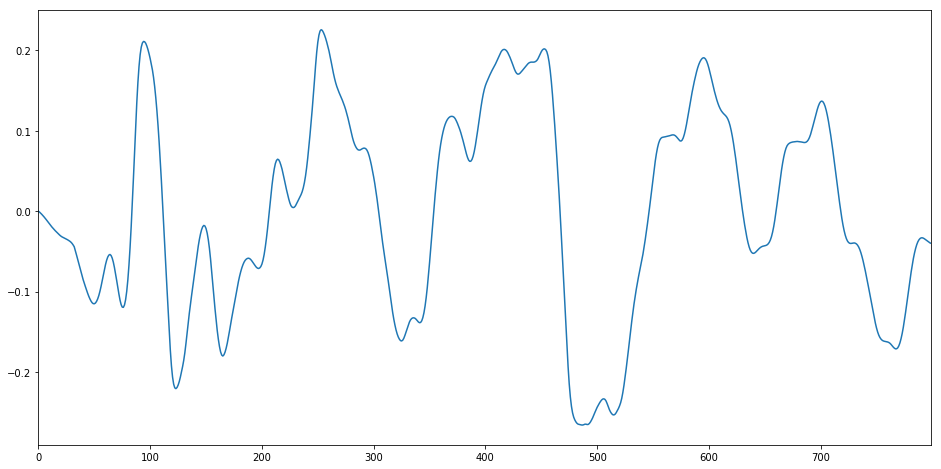

In [26]:
pd.Series(y_tr_n[:800]).plot.line(figsize=(16, 8))

In [27]:

X_te_n.min(), X_te_n.max(), np.mean(X_te_n)

(-0.1662038, 0.23468734, 1.2222178e-05)

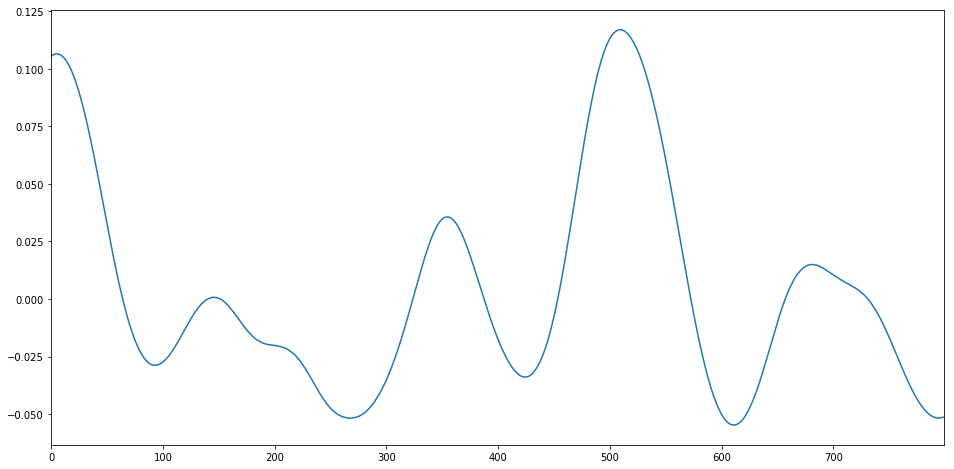

In [28]:
pd.Series(X_te_n[:800]).plot.line(figsize=(16, 8))

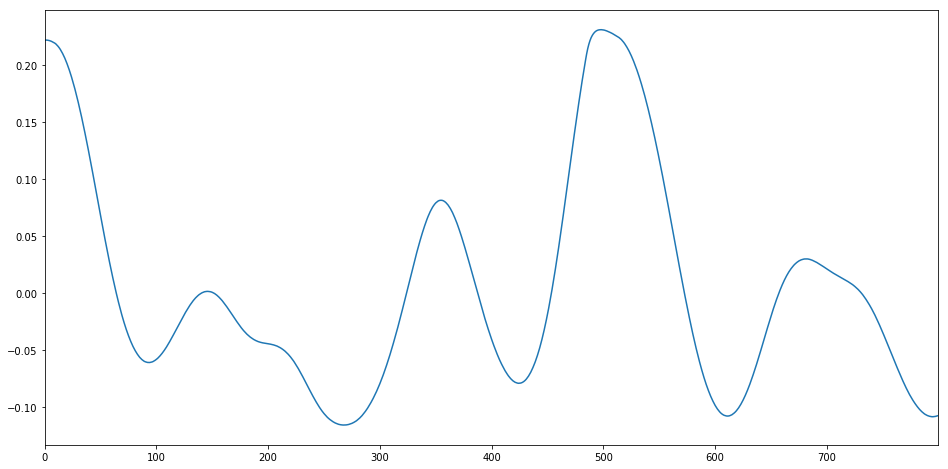

In [29]:
pd.Series(y_te_n[:800]).plot.line(figsize=(16, 8))

In [30]:
# appending stats of the whole sample, fading from silence

In [31]:
# train_shuffle_index = np.random.shuffle(np.arange(0, len(X_tr_n)))
# test_shuffle_index = np.random.shuffle(np.arange(0, len(X_te_n)))

# X_tr_f = X_tr_n[train_shuffle_index][0]
# y_tr_f = y_tr_n[train_shuffle_index][0]

# X_te_f = X_te_n[test_shuffle_index][0]
# y_te_f = y_te_n[test_shuffle_index][0]

## Making windows

In [32]:
# N_WINDOW_POINTS = int(source_clean_fs * 0.02)
N_WINDOW_POINTS = 64
N_WINDOW_POINTS

64

In [33]:
N_SAMPLES = 44000 * 3
N_SAMPLES

132000

In [34]:
def make_windows(X, y, n_window_points):
    X_index = X.index
    index = 0
    
    res_X = []
    res_y = []

    for index in range(0, len(X) - n_window_points - 1):
        res_X.append(X.iloc[index:(index + n_window_points)])
#         res_y.append(y.iloc[index + n_window_points])
        res_y.append(y.iloc[index + n_window_points - 1])

    return (np.array(res_X), np.array(res_y))

In [35]:
%%time
(X_tr_f, y_tr_f) = make_windows(
    pd.Series(X_tr_n[:(N_SAMPLES + N_WINDOW_POINTS + 1)]),
    pd.Series(y_tr_n[:(N_SAMPLES + N_WINDOW_POINTS + 1)]),
    N_WINDOW_POINTS)
print((len(X_tr_f), X_tr_f[0], y_tr_f[0]))

(132000, array([ 3.05185094e-05, -1.52592547e-04, -3.35703604e-04, -5.49333170e-04,
       -7.32444227e-04, -9.15555283e-04, -1.12918485e-03, -1.40385143e-03,
       -1.61748100e-03, -1.86162908e-03, -2.10577715e-03, -2.38044374e-03,
       -2.59407330e-03, -2.80770287e-03, -3.02133244e-03, -3.23496200e-03,
       -3.38755455e-03, -3.54014710e-03, -3.75377666e-03, -3.93688772e-03,
       -4.08948027e-03, -4.21155430e-03, -4.30310983e-03, -4.39466536e-03,
       -4.45570238e-03, -4.57777642e-03, -4.69985045e-03, -4.79140598e-03,
       -4.94399853e-03, -5.06607257e-03, -5.31022064e-03, -5.52385021e-03,
       -5.85955381e-03, -6.50044251e-03, -7.14133121e-03, -7.87377544e-03,
       -8.54518265e-03, -9.27762687e-03, -9.94903408e-03, -1.06814783e-02,
       -1.12918485e-02, -1.18717002e-02, -1.24820704e-02, -1.30619220e-02,
       -1.36722922e-02, -1.42216254e-02, -1.47404401e-02, -1.51982177e-02,
       -1.55949583e-02, -1.58391073e-02, -1.59306619e-02, -1.58391073e-02,
       -1.559495

In [36]:
X_tr_f[1], y_tr_f[1]

(array([-0.00015259, -0.0003357 , -0.00054933, -0.00073244, -0.00091556,
        -0.00112918, -0.00140385, -0.00161748, -0.00186163, -0.00210578,
        -0.00238044, -0.00259407, -0.0028077 , -0.00302133, -0.00323496,
        -0.00338755, -0.00354015, -0.00375378, -0.00393689, -0.00408948,
        -0.00421155, -0.00430311, -0.00439467, -0.0044557 , -0.00457778,
        -0.00469985, -0.00479141, -0.004944  , -0.00506607, -0.00531022,
        -0.00552385, -0.00585955, -0.00650044, -0.00714133, -0.00787378,
        -0.00854518, -0.00927763, -0.00994903, -0.01068148, -0.01129185,
        -0.0118717 , -0.01248207, -0.01306192, -0.01367229, -0.01422163,
        -0.01474044, -0.01519822, -0.01559496, -0.01583911, -0.01593066,
        -0.01583911, -0.01559496, -0.01519822, -0.01461837, -0.01388592,
        -0.0130314 , -0.01211585, -0.01113926, -0.01019318, -0.00924711,
        -0.00851466, -0.00793481, -0.00759911, -0.00747703], dtype=float32),
 -0.053773616)

In [37]:
%%time
(X_te_f, y_te_f) = make_windows(
    pd.Series(X_te_n[:(N_SAMPLES + N_WINDOW_POINTS + 1)]),
    pd.Series(y_te_n[:(N_SAMPLES + N_WINDOW_POINTS + 1)]),
    N_WINDOW_POINTS
)
print((len(X_te_f), X_te_f[0], y_te_f[0]))

(132000, array([0.105533  , 0.10586871, 0.1061739 , 0.10635701, 0.1065096 ,
       0.10654011, 0.10647908, 0.10635701, 0.1061739 , 0.10592975,
       0.105533  , 0.10507523, 0.10455641, 0.10391553, 0.1032136 ,
       0.10242012, 0.10153508, 0.10058901, 0.09955138, 0.09839167,
       0.09720145, 0.09588916, 0.09454634, 0.09305093, 0.09155553,
       0.08990753, 0.08822901, 0.08648945, 0.08465835, 0.0827662 ,
       0.08084353, 0.07882931, 0.07672353, 0.07458724, 0.07238991,
       0.07016205, 0.06787317, 0.06552324, 0.0631428 , 0.06073184,
       0.05829035, 0.05578784, 0.05328532, 0.0507828 , 0.04821924,
       0.04565569, 0.04306162, 0.04049806, 0.03790399, 0.03530991,
       0.03277688, 0.03021332, 0.02764977, 0.02517777, 0.02264473,
       0.02023377, 0.01782281, 0.01544237, 0.01312296, 0.01083407,
       0.00860622, 0.00640889, 0.00424207, 0.00219733], dtype=float32), 0.0045777764)
CPU times: user 18.1 s, sys: 182 ms, total: 18.2 s
Wall time: 18.3 s


In [38]:
X_te_f[1], y_te_f[1]

(array([0.10586871, 0.1061739 , 0.10635701, 0.1065096 , 0.10654011,
        0.10647908, 0.10635701, 0.1061739 , 0.10592975, 0.105533  ,
        0.10507523, 0.10455641, 0.10391553, 0.1032136 , 0.10242012,
        0.10153508, 0.10058901, 0.09955138, 0.09839167, 0.09720145,
        0.09588916, 0.09454634, 0.09305093, 0.09155553, 0.08990753,
        0.08822901, 0.08648945, 0.08465835, 0.0827662 , 0.08084353,
        0.07882931, 0.07672353, 0.07458724, 0.07238991, 0.07016205,
        0.06787317, 0.06552324, 0.0631428 , 0.06073184, 0.05829035,
        0.05578784, 0.05328532, 0.0507828 , 0.04821924, 0.04565569,
        0.04306162, 0.04049806, 0.03790399, 0.03530991, 0.03277688,
        0.03021332, 0.02764977, 0.02517777, 0.02264473, 0.02023377,
        0.01782281, 0.01544237, 0.01312296, 0.01083407, 0.00860622,
        0.00640889, 0.00424207, 0.00219733, 0.00015259], dtype=float32),
 0.0003357036)

In [39]:
# import numpy as np

# train_shuffle_index = np.arange(0, len(X_tr_f))
# np.random.shuffle(train_shuffle_index)

# test_shuffle_index = np.arange(0, len(X_te_f))
# np.random.shuffle(test_shuffle_index)

# X_tr_f = np.array(X_tr_f)[train_shuffle_index]
# y_tr_f = np.array(y_tr_f)[train_shuffle_index]

# X_te_f = np.array(X_te_f)[test_shuffle_index]
# y_te_f = np.array(y_te_f)[test_shuffle_index]

# X_tr_f[0], y_tr_f[0], len(X_tr_f), len(y_tr_f), len(X_te_f), len(y_te_f)

In [40]:
# X_tr_f = X_tr_n
# y_tr_f = y_tr_n

# X_te_f = X_te_n
# y_te_f = y_te_n

In [41]:
(len(X_tr_f), len(y_tr_f), len(X_te_f), len(y_te_f))

(132000, 132000, 132000, 132000)

In [42]:
# list(map(lambda row: row[:N_PEAKS*2], X_tr_f))[0]
# # list(map(lambda row: row[:N_PEAKS], X_tr_f))[0]

In [43]:
# from matplotlib import pyplot as plt

# # amp_df = pd.DataFrame(list(map(lambda row: row[N_PEAKS:N_PEAKS*2], X_tr_f)))
# amp_df = pd.DataFrame(list(map(lambda row: row, X_tr_f)))

# f = plt.figure(figsize=(19, 15))
# plt.matshow(amp_df.corr())
# plt.xticks(range(amp_df.shape[1]), amp_df.columns, fontsize=14, rotation=45)
# plt.yticks(range(amp_df.shape[1]), amp_df.columns, fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
# plt.title('Correlation Matrix', fontsize=16);

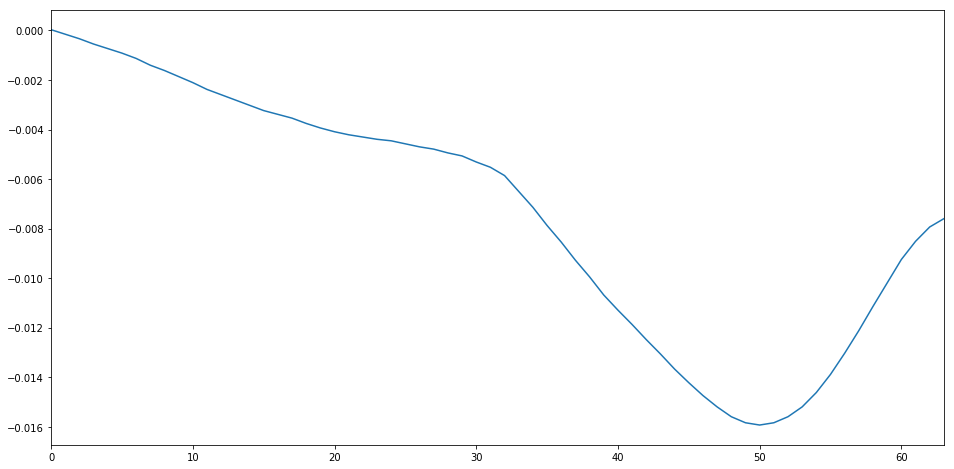

In [44]:
pd.Series(X_tr_f[0]).plot.line(figsize=(16, 8))

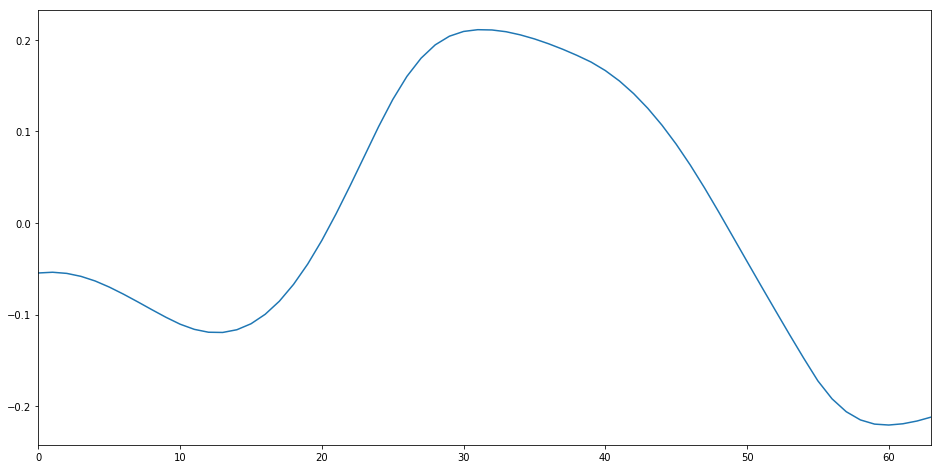

In [45]:
pd.Series(y_tr_f[:N_WINDOW_POINTS]).plot.line(figsize=(16, 8))

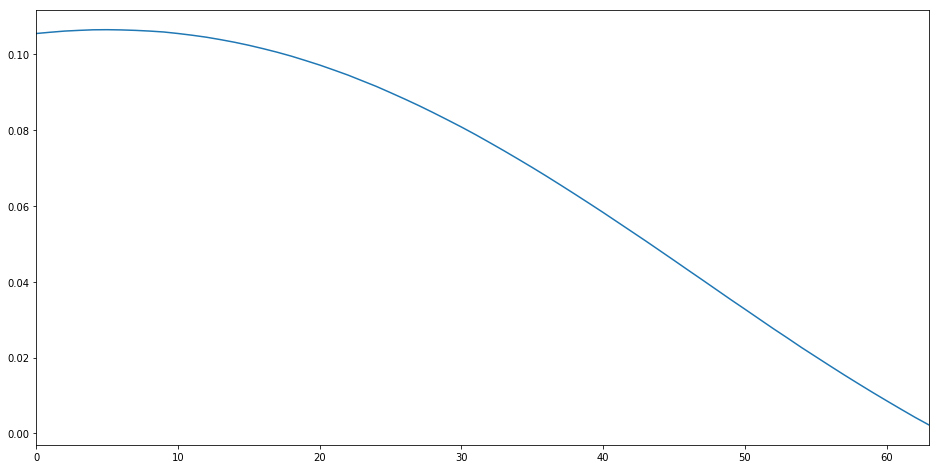

In [46]:
pd.Series(X_te_f[0]).plot.line(figsize=(16, 8))

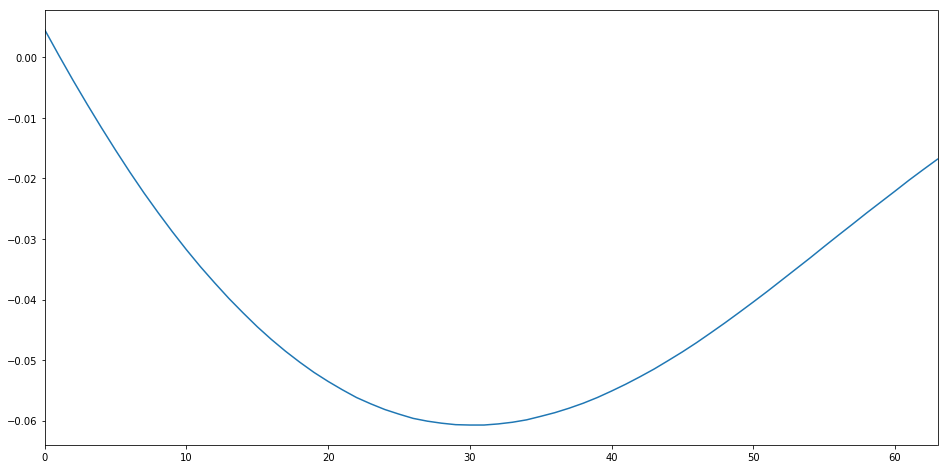

In [47]:
pd.Series(y_te_f[:N_WINDOW_POINTS]).plot.line(figsize=(16, 8))

In [48]:
n_features = 1

In [49]:
(X_tr_f[0], y_tr_f[0])

(array([ 3.05185094e-05, -1.52592547e-04, -3.35703604e-04, -5.49333170e-04,
        -7.32444227e-04, -9.15555283e-04, -1.12918485e-03, -1.40385143e-03,
        -1.61748100e-03, -1.86162908e-03, -2.10577715e-03, -2.38044374e-03,
        -2.59407330e-03, -2.80770287e-03, -3.02133244e-03, -3.23496200e-03,
        -3.38755455e-03, -3.54014710e-03, -3.75377666e-03, -3.93688772e-03,
        -4.08948027e-03, -4.21155430e-03, -4.30310983e-03, -4.39466536e-03,
        -4.45570238e-03, -4.57777642e-03, -4.69985045e-03, -4.79140598e-03,
        -4.94399853e-03, -5.06607257e-03, -5.31022064e-03, -5.52385021e-03,
        -5.85955381e-03, -6.50044251e-03, -7.14133121e-03, -7.87377544e-03,
        -8.54518265e-03, -9.27762687e-03, -9.94903408e-03, -1.06814783e-02,
        -1.12918485e-02, -1.18717002e-02, -1.24820704e-02, -1.30619220e-02,
        -1.36722922e-02, -1.42216254e-02, -1.47404401e-02, -1.51982177e-02,
        -1.55949583e-02, -1.58391073e-02, -1.59306619e-02, -1.58391073e-02,
        -1.5

In [50]:
X_tr_s = X_tr_f.reshape(X_tr_f.shape[0], X_tr_f.shape[1], 1)
X_tr_s[0][:5]

array([[ 3.0518509e-05],
       [-1.5259255e-04],
       [-3.3570360e-04],
       [-5.4933317e-04],
       [-7.3244423e-04]], dtype=float32)

In [51]:
y_tr_s = y_tr_f

In [52]:
X_te_s = X_te_f.reshape(X_te_f.shape[0], X_te_f.shape[1], 1)
X_te_s[0][:5]

array([[0.105533  ],
       [0.10586871],
       [0.1061739 ],
       [0.10635701],
       [0.1065096 ]], dtype=float32)

In [53]:
y_te_s = y_te_f

In [54]:
def add_stats(row):
    stats = [
        np.abs(row[-1]),
        -np.abs(row[-1]),
#         np.mean(row),
#         np.max(row),
#         np.min(row),
#         np.var(row)
    ]

    return np.array([(list(x) + list(stats)) for x in row])

In [55]:
# %%time
# X_tr_s = np.array([add_stats(row) for row in X_tr_s])
# print(X_tr_s[0][0], X_tr_s[0][1])

In [56]:
# %%time
# X_te_s = np.array([add_stats(row) for row in X_te_s])
# print(X_te_s[0][0], X_te_s[0][1])

In [57]:
N_REPEAT = 4
N_REPEAT

4

In [58]:
X_tr_s[0][0]

array([3.051851e-05], dtype=float32)

In [59]:
# X_tr_s = np.repeat(X_tr_s, N_REPEAT, axis=0)
# X_tr_s[0][0], X_tr_s[1][0]

In [60]:
# y_tr_s = np.repeat(y_tr_s, N_REPEAT, axis=0)
# y_tr_s[0], y_tr_s[1]

In [61]:
# X_te_s = np.repeat(X_te_s, N_REPEAT, axis=0)
# X_te_s[0][0], X_te_s[1][0]

In [62]:
# y_te_s = np.repeat(y_te_s, N_REPEAT, axis=0)
# y_tr_s[0], y_tr_s[1]

## Finished data processing!

## Moving on to training NN

In [63]:
import numpy as np

In [64]:
# num_steps=100, 24 hidden states

In [65]:
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, Reshape, GRU, GaussianNoise
from keras.layers import Convolution2D, MaxPooling2D, Layer, Input, BatchNormalization
from keras.utils import np_utils
from keras.regularizers import L1L2
from keras.layers.merge import concatenate

tf.set_random_seed(1234)

Using TensorFlow backend.


In [66]:
X_tr_s.shape, y_tr_s.shape, X_te_s.shape, y_te_s.shape

((132000, 64, 1), (132000,), (132000, 64, 1), (132000,))

In [67]:
y_tr_s

array([-0.05456709, -0.05377362, -0.05502487, ..., -0.16183965,
       -0.1688284 , -0.17465743], dtype=float32)

In [68]:
from keras import backend as K
from keras.layers import Layer

class DebugLayer(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(DebugLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(DebugLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        print(x[0])
        return x

In [109]:
from scipy.signal import savgol_filter
from matplotlib import pyplot as plt


# TensorBoard callback
# tensorboard_cb = keras.callbacks.TensorBoard(
#     log_dir='./logs',
#     batch_size=BATCH_SIZE,
#     # histogram_freq='batch',
#     write_graph=True,
#     write_grads=True,
#     write_images=True
# )

class TestModel(keras.callbacks.Callback):
    def __init__(self, model, I=200, batch_size=1):
        self.model = model
        self.I = I
        self.batch_size = batch_size
        
    def on_train_begin(self, epoch_n):
#         (fig, ax) = plt.subplots(figsize=(12, 8))
        I = self.I
        (fig, ax) = plt.subplots()
        self.fig = fig
        self.ax = ax
        
        feat = pd.Series((np.array(list(map(lambda row: row[-1][0], X_tr_s[:I])))))

        feat_data, =  ax.plot(feat.values, label='feature')

        targ = (pd.Series((y_tr_s[:I])))

        pred = pd.Series(np.zeros(I))
        # pred = (pred * 2.2) + 0.001
        pred = pred + 0.001

        zeros = pd.Series(np.zeros(I))
        zeros.plot.line(ax=ax, label='0')

        targ_data, = ax.plot(targ.values, label='target')

        pred_data, = ax.plot(pred.values, label='predicted')
        # pd.Series(savgol_filter(pred, 5, 3)).plot.line(ax=ax, label='savgol(predicted)')
        
        self.feat_data = feat_data
        self.targ_data = targ_data
        self.pred_data = pred_data
        
        ax.legend(loc='upper right')
        ax.set_title('NN predictions on first {} samples'.format(I))
        ax.set_xlabel('index')
        ax.set_ylabel('value')
        
        plt.show()
        fig.canvas.draw()
        
        
    def on_epoch_end(self, epoch_n, logs={}):
        model = self.model
        
        fig = self.fig
        ax = self.ax
        
        I = self.I
        batch_size = self.batch_size

        feat = pd.Series((np.array(list(map(lambda row: row[-1][0], X_tr_s[:I])))))

        self.feat_data.set_ydata(feat.values)

        targ = (pd.Series((y_tr_s[:I])))

        pred = pd.Series(predict(model, X_tr_s[:I], batch_size=batch_size))
        # pred = (pred * 2.2) + 0.001
        pred = pred + 0.001

        # zeros = pd.Series(np.zeros(I))
        # zeros.plot.line(ax=ax, label='0')

        self.targ_data.set_ydata(targ.values)

        self.pred_data.set_ydata(pred.values)
        # pd.Series(savgol_filter(pred, 5, 3)).plot.line(ax=ax, label='savgol(predicted)')

        # pd.Series(normalize(np.array(list(map(lambda w: w[-1], X_tr_f[:I]))))).plot.line(ax=ax, label='feature')

        ax.set_title('NN predictions on first {} samples, epoch {}'.format(I, epoch_n))
        
        fig.canvas.draw()


# Callback to display the target and prediciton
# test_model_cb = keras.callbacks.LambdaCallback(on_epoch_end=testmodel)

In [124]:
from keras import backend as K
    
N_UNITS = 24
BATCH_SIZE = 1

def load_model(filepath):
    model = keras.models.load_model(filepath)
    
    return model
    
    
    
def create_model(params):
    print(params)
    
    input_L = Input(
        shape=(N_WINDOW_POINTS, n_features),
        batch_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
    )

    # bn_L = (BatchNormalization()(input_L))

    gru_1_L = GRU(
        params['n_units'],
        input_shape=(N_WINDOW_POINTS, n_features),
        batch_input_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
        # bias_regularizer=L1L2(l1=0.1, l2=0.1),
        stateful=True,
        # reset_after=True,
        # batch_input_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
        activation='tanh',
        recurrent_activation='hard_sigmoid',
        # kernel_initializer=keras.initializers.RandomNormal(stddev=0.1),
        kernel_initializer=keras.initializers.glorot_uniform(seed=43),
#         recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=42),
        recurrent_initializer=keras.initializers.glorot_uniform(seed=43),
        # kernel_initializer='identity',
        bias_initializer='zeros',
        return_sequences=True,
    )(input_L)

    gru_2_L = GRU(
        params['n_units'],
        input_shape=(N_WINDOW_POINTS, n_features),
        batch_input_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
        # bias_regularizer=L1L2(l1=0.1, l2=0.1),
        stateful=True,
        # reset_after=True,
        # batch_input_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
        activation='tanh',
        recurrent_activation='hard_sigmoid',
        # kernel_initializer=keras.initializers.RandomNormal(stddev=0.1),
        kernel_initializer=keras.initializers.glorot_uniform(seed=43),
#         recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=42),
        recurrent_initializer=keras.initializers.glorot_uniform(seed=43),
        # kernel_initializer='identity',
        bias_initializer='zeros',
    #     return_sequences=True,
    )(gru_1_L)

    dense_2_l = Dense(
        1,
        activation=None,
        kernel_initializer='identity',
        bias_initializer='zeros',
    # )(gru_1_l)
    )(gru_2_L)


    model = Model(inputs=input_L, outputs=dense_2_l)
    
    return model

    

def train_model(model, X_tr, y_tr, x_val, y_val, params):
    optimizer = keras.optimizers.adam(lr=params['lr'], clipvalue=10, clipnorm=10)
    # optimizer = keras.optimizers.SGD(lr=params['lr'], decay=0.2)


    def mean_squared_error(y_true, y_pred):
        return K.mean(K.square(10 * (y_pred - y_true)), axis=-1)

    # model.compile(optimizer=optimizer, loss='mse')
    model.compile(optimizer=optimizer, loss='mae')
    
    # TRAIN

    es_cb = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0005,
        patience=8,
        verbose=0,
        mode='auto',
    )

    def step_decay(epoch):
        initial_lrate = params['lr']
        drop = 0.8
        epochs_drop = 20.0
        lrate = initial_lrate * math.pow(drop,  
               math.floor((1+epoch)/epochs_drop))
        return lrate

    lrate = keras.callbacks.LearningRateScheduler(step_decay)

    test_model_cb = TestModel(model, I=min(params['n_samples'], 400), batch_size=params['batch_size'])

    history = model.fit(
        X_tr_s[:params['n_samples']],
        y_tr_s[:params['n_samples']],
#         X_tr_s[:40],
#         y_tr_s[:40],
        batch_size=params['batch_size'],
        shuffle=False,
    #     epochs=400,
#         epochs=100,
        epochs=params['epochs'],
        verbose=1,
        # validation_data=(X_te_s[:400], y_te_s[:400]),
        # validation_data=(X_te_s[:200], y_te_s[:200]),
        # callbacks=[es_cb, test_model_cb, tensorboard_cb],
        callbacks=[es_cb, test_model_cb, lrate],
    )
    
    return (history, model)

In [71]:
import math

def predict(model, X_input, batch_size=1):
    # X_input = np.array(rows).reshape(rows.shape[0], rows.shape[1], n_features)
    
    return np.array(
        model.predict(
            X_input[:(math.floor(len(X_input) / batch_size) * batch_size)], batch_size=batch_size
        )
    ).flatten()


  0%|          | 0/9 [00:00<?, ?it/s]

{'lr': 0.003, 'n_samples': 80, 'n_units': 16, 'batch_size': 10, 'epochs': 10, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


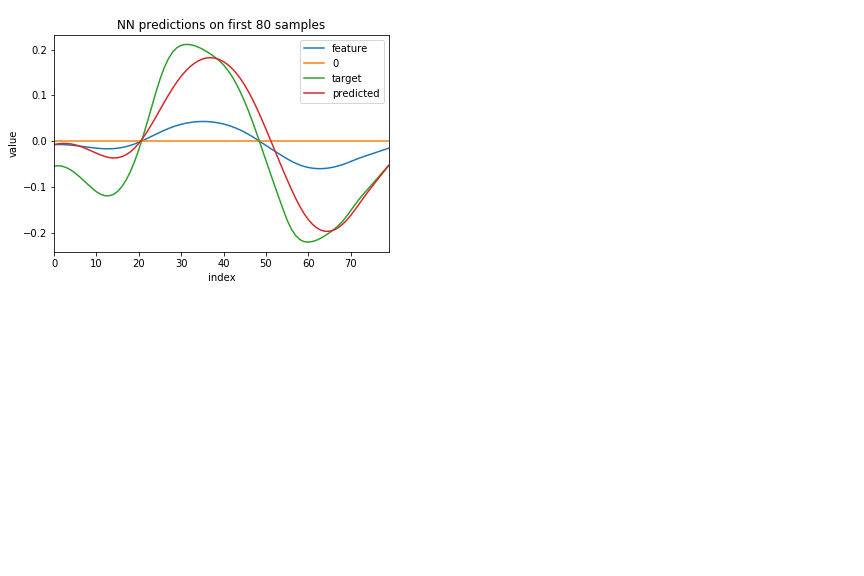

Epoch 1/10
80/80 [==============================] - 2s 26ms/step - loss: 0.1134
Epoch 2/10
80/80 [==============================] - 0s 6ms/step - loss: 0.0880
Epoch 3/10
80/80 [==============================] - 0s 6ms/step - loss: 0.0746
Epoch 4/10
80/80 [==============================] - 0s 5ms/step - loss: 0.0485
Epoch 5/10
10/80 [==>...........................] - ETA: 0s - loss: 0.0602

KeyboardInterrupt: 

In [94]:
from keras.optimizers import Adam, Nadam, RMSprop
import talos as ta

p = {
     'lr': [0.001, 0.003, 0.01],
     'n_samples': [80],
     'n_units': [4, 8, 16],
#      'batch_size': [10, 100, 1000],
     'batch_size': [10],
     'epochs': [10],
     # 'dropout': (0, 0.5, 5),
     # 'weight_regulizer':[None],
     # 'emb_output_dims': [None],
     # 'shape':['brick','long_funnel'],
     'optimizer': [Adam],
 }
#     'lr': 0.001,
#     'n_samples': 20,
#     'n_units': 24,
#     'batch_size': 10,
#     'epochs': 100,
#     'optimizer': keras.optimizers.Adam,

# and run the experiment
t = ta.Scan(x=X_tr_s[:np.max(p['n_samples'])],
            y=y_tr_s[:np.max(p['n_samples'])],
            model=create_lstm_model,
#             grid_downsample=0.5,
            params=p,
            experiment_no='3')


In [ ]:
r = ta.Reporting(t)
r.data.sort_values(by='loss')

In [ ]:
best_params = r.data.loc[3]
best_params

In [ ]:
type(best_params)

<IPython.core.display.Javascript object>


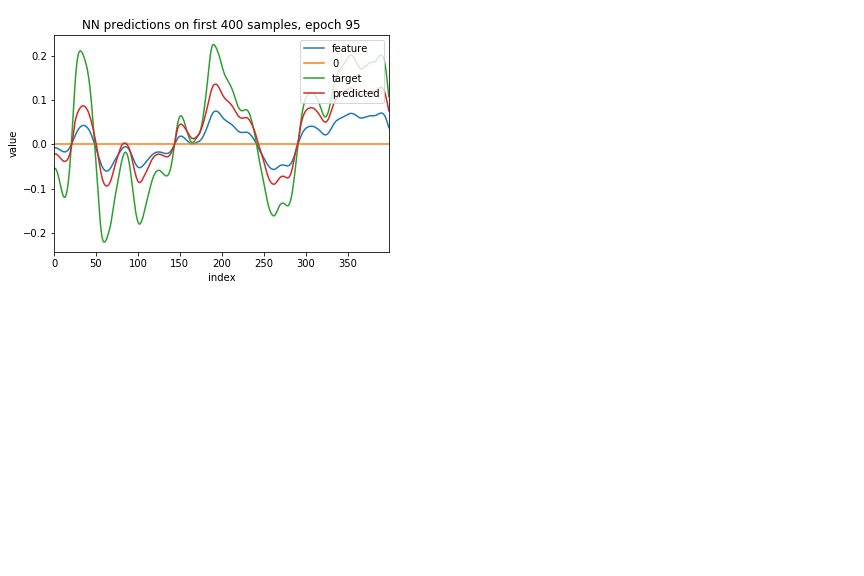

Epoch 1/1000
1000/1000 [==============================] - 37s 37ms/step - loss: 0.0206
Epoch 2/1000
1000/1000 [==============================] - 32s 32ms/step - loss: 0.0192
Epoch 3/1000
1000/1000 [==============================] - 32s 32ms/step - loss: 0.0198
Epoch 4/1000
1000/1000 [==============================] - 32s 32ms/step - loss: 0.0162
Epoch 5/1000
1000/1000 [==============================] - 32s 32ms/step - loss: 0.0149
Epoch 6/1000
1000/1000 [==============================] - 32s 32ms/step - loss: 0.0130
Epoch 7/1000
1000/1000 [==============================] - 32s 32ms/step - loss: 0.0171
Epoch 8/1000
1000/1000 [==============================] - 32s 32ms/step - loss: 0.0185
Epoch 9/1000
1000/1000 [==============================] - 32s 32ms/step - loss: 0.0147
Epoch 10/1000
1000/1000 [==============================] - 32s 32ms/step - loss: 0.0170
Epoch 11/1000
1000/1000 [==============================] - 32s 32ms/step - loss: 0.0139
Epoch 12/1000
1000/1000 [================

1000/1000 [==============================] - 31s 31ms/step - loss: 0.0168
Epoch 95/1000
1000/1000 [==============================] - 31s 31ms/step - loss: 0.0172
Epoch 96/1000
1000/1000 [==============================] - 31s 31ms/step - loss: 0.0152
Epoch 97/1000
 795/1000 [======================>.......] - ETA: 6s - loss: 0.0205

In [ ]:
%matplotlib notebook

best_params = {
    'lr': 0.002,
    'n_samples': 1000,
    'n_units': 4,
    'batch_size': 1,
    'epochs': 1000,
    'optimizer': keras.optimizers.Adam,
}

model = load_model('saved_models/02_peak_comp_60_samples_180_params.h5')

history, model = train_model(
    model,
    X_tr_s[:best_params['n_samples']],
    y_tr_s[:best_params['n_samples']],
    X_te_s[:best_params['n_samples']],
    y_te_s[:best_params['n_samples']],
    best_params
)

In [74]:
for layer in model.layers:
    weights = layer.get_weights() # list of numpy arrays
    print(weights)
    print('='*20)

[]
[array([[-1.9930363 , -1.2088823 , -1.1665124 , -1.140611  , -0.7802299 ,
        -1.1415867 ,  0.12047306, -1.9630934 , -1.1389594 , -1.209383  ,
        -1.134794  , -1.096016  ,  0.433691  , -0.4553654 ,  0.09966512,
         1.0256974 ,  0.41399953,  0.21791226,  0.51552   ,  0.21770333,
        -0.61797005,  0.19831754,  0.05508596, -0.42689335, -0.65467656,
         0.8000907 , -0.89630324, -0.8627992 , -0.59065855, -1.049858  ,
         0.43339992, -0.59059125,  0.7194685 , -0.78309107, -0.82719594,
         0.17884956]], dtype=float32), array([[ 1.2203827 ,  0.02094106,  0.6388866 ,  0.2571571 ,  0.8630593 ,
         0.34670594, -0.52400476,  1.6844049 ,  0.24042723,  0.69954675,
         0.3431363 ,  0.49449903,  0.04901066, -0.12439268, -0.16947392,
         0.0691731 ,  0.00745368, -0.27421176, -0.34575865, -0.35508114,
         0.10818075, -0.14461496,  0.19733547, -0.20969532,  0.13264662,
         0.36339673, -0.06876902, -0.29333365,  0.01228736, -0.33093742,
        

In [99]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (1, 64, 1)                0         
_________________________________________________________________
gru_13 (GRU)                 (1, 64, 4)                72        
_________________________________________________________________
gru_14 (GRU)                 (1, 4)                    108       
_________________________________________________________________
dense_7 (Dense)              (1, 1)                    5         
Total params: 185
Trainable params: 185
Non-trainable params: 0
_________________________________________________________________


In [101]:
# model.save('saved_models/02_peak_comp_60_samples_180_params.h5')

In [76]:
score = model.evaluate(X_te_s[:400], y_te_s[:400], verbose=0, batch_size=BATCH_SIZE)
score

0.0947332183358958

In [77]:
0.0947332183358958

0.0947332183358958

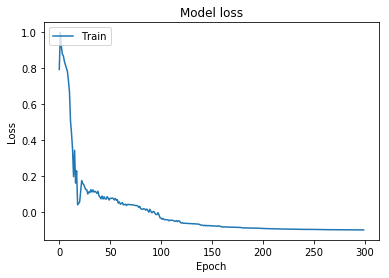

In [98]:
%matplotlib inline

from matplotlib import pyplot as plt

# Plot training & validation loss values
plt.plot(normalize(np.array(history.history['loss'])))
# plt.plot(normalize(np.array(history.history['val_loss'])))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [ ]:
len(X_te_f)

In [ ]:
predict(model, X_te_s[:100])

In [ ]:
print(X_tr_s[0][-1])

0   -0.055320
1   -0.053671
2   -0.054124
3   -0.056173
4   -0.059953
dtype: float32


Text(0,0.5,'value')

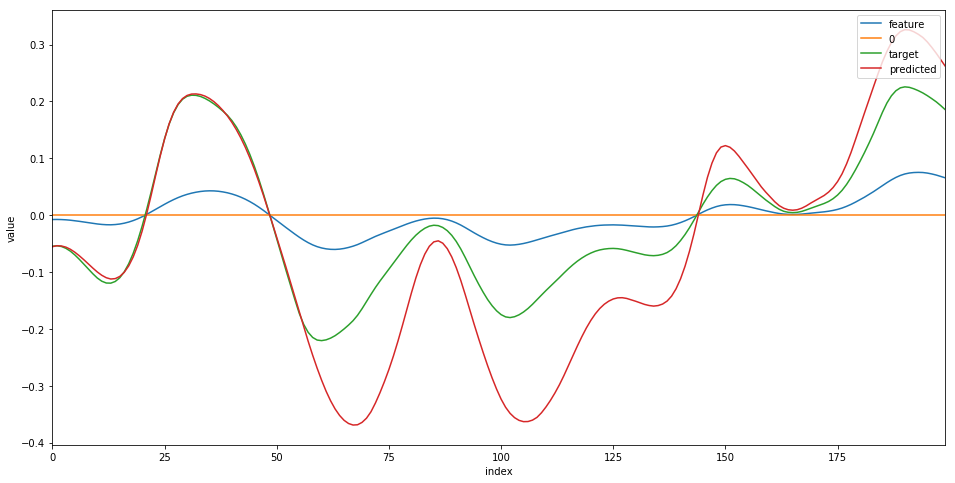

In [100]:
%matplotlib inline
from scipy.signal import savgol_filter

(fig, ax) = plt.subplots(figsize=(16, 8))

I = 200

feat = pd.Series((np.array(list(map(lambda row: row[-1][0], X_tr_s[:I])))))

feat.plot.line(ax=ax, label='feature')

targ = (pd.Series((y_tr_s[:I])))

pred = pd.Series(predict(model, X_tr_s[:I]))
pd.Series(predict(model, X_tr_s[:I]))
# pred = (pred * 3.2) + 0.001
pred = pred + 0.001

zeros = pd.Series(np.zeros(I))
zeros.plot.line(ax=ax, label='0')

targ.plot.line(ax=ax, label='target')

print(pred[:5])

pred.plot.line(ax=ax, label='predicted')
# pd.Series(savgol_filter(pred, 5, 3)).plot.line(ax=ax, label='savgol(predicted)')

# pd.Series(normalize(np.array(list(map(lambda w: w[-1], X_tr_f[:I]))))).plot.line(ax=ax, label='feature')

ax.legend(loc="upper right")
ax.set_xlabel('index')
ax.set_ylabel('value')

## Time to evaluate performance

In [ ]:
predictions = predict(model, X_tr_s[:(44000 * 3)], batch_size=best_params['batch_size'])
len(predictions), predictions[:10], np.max(predictions), np.min(predictions)

In [ ]:
predictions_n = predictions / (max(abs(np.max(predictions)), abs(np.min(predictions)))) * MAX_VALUE
len(predictions_n), predictions_n[:10], np.max(predictions_n), np.min(predictions_n)

In [ ]:
wavfile.write('output/pred_out.wav', source_fs, predictions)

In [ ]:
len(predictions)